In [1]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

### Loading the Book Ratings Dataset

In [2]:
ratings = pd.read_csv('../raw-data/BX-Book-Ratings.csv', encoding='iso-8859-1', sep = ';')
ratings.columns = ['user_id', 'isbn', 'book_rating']

In [3]:
print(ratings.dtypes)
print()
print(ratings.head())
print()
print("Data Points :", ratings.shape[0])

user_id         int64
isbn           object
book_rating     int64
dtype: object

   user_id        isbn  book_rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6

Data Points : 1149780


### Loading the Books Dataset

In [60]:
books = pd.read_csv('../raw-data/BX-Books.csv', sep=';', encoding = 'iso-8859-1', dtype =str)
del books['Image-URL-L']
del books['Image-URL-M']
del books['Image-URL-S']
del books['Book-Author']
del books['Publisher']

Some Books don't have unique ISBN, creating a 1:1 maping between books-title and ISBN

In [61]:
print('Number of Books == Number of ISBN ? ', books["Book-Title"].nunique() == books["ISBN"].nunique())
book_dict = books[["Book-Title","ISBN"]].set_index("Book-Title").to_dict()["ISBN"]
books['new_isbn'] = books["Book-Title"].apply(lambda x: book_dict[x])
print('Number of Books == Number of ISBN ? ', books["Book-Title"].nunique() == books["new_isbn"].nunique())

Number of Books == Number of ISBN ?  False
Number of Books == Number of ISBN ?  True


In [62]:
books['isbn'] = books['new_isbn']

del books['ISBN']
del books['new_isbn']

### Data Preparation/ Cleaning <br>

Removing ratings equal to zero, since Book Crossing Dataset has rating scale from 1-10. Taking Inner Join with books dataframe to maintain books whose details exist.

In [63]:
newdf = ratings[ratings.book_rating>0]
joined = books.merge(newdf, on ='isbn')
print(newdf.shape)

(433671, 3)


### Sampling <br>

Book Crossing Dataset is a very sparse Dataset with sparsity of more than 99.99%. In order to choose a small subset of dataset with constraints given in the dataset, we selected top 100 items which have been rated the most and took intersection with top 20000 users who have given ratings to more books. Further we remove all users who rated only one book to make the data more denser. This gave a dataset with 2517 users and 100 items with 8242 data points. In order to verify the scalability of our model we created different dataset with increasing book counts (150, 200, 300, 500)

In [58]:
datasets = []
for j in [100, 150, 200, 300, 500]:
    df = joined.groupby('isbn').count().sort_values('user_id', ascending =False)[0:j].index.values
    test = joined.groupby('user_id').count().sort_values('isbn', ascending = False)[:20000].index.values
    newdf = joined[joined.user_id.isin(test) & joined.isbn.isin(df)]
    data  = newdf[newdf['user_id'].isin(newdf['user_id'].value_counts()[newdf['user_id'].value_counts()>1].index)]
    print("users books")
    print(data.user_id.nunique(), data.isbn.nunique())
    print()
    print('Sparsity :', data.shape[0]/(data.user_id.nunique() * data.isbn.nunique()))
    print()
    print(data.shape)
    print()
    print(data.groupby('user_id').count().sort_values('isbn', ascending = False).mean())
    print()
    datasets.append(data)

users books
2517 100

Sparsity : 0.03274533174413985

(8242, 5)

Book-Title             3.274533
Year-Of-Publication    3.274533
isbn                   3.274533
book_rating            3.274533
dtype: float64

users books
3086 150

Sparsity : 0.023393821559732124

(10829, 5)

Book-Title             3.509073
Year-Of-Publication    3.509073
isbn                   3.509073
book_rating            3.509073
dtype: float64

users books
3543 200

Sparsity : 0.01872847869037539

(13271, 5)

Book-Title             3.745696
Year-Of-Publication    3.745696
isbn                   3.745696
book_rating            3.745696
dtype: float64

users books
4280 300

Sparsity : 0.013364485981308412

(17160, 5)

Book-Title             4.009346
Year-Of-Publication    4.009346
isbn                   4.009346
book_rating            4.009346
dtype: float64

users books
5282 500

Sparsity : 0.008777357061719046

(23181, 5)

Book-Title             4.388679
Year-Of-Publication    4.388679
isbn                   4.388

Taking Dataset with 100 items

# Algo 1: Memory Based Algorithm : Item-Item CF Algorithm

Since average number of books rated by an user was around 3.3, we decided to use item-item CF as our memory based algorithm. Our implementation of item-item algorithm is below:

In [9]:
data = datasets[0]
rows = data.user_id.unique()
cols = data['Book-Title'].unique()
print(data.user_id.nunique(), data.isbn.nunique())
data = data[['user_id', 'Book-Title', 'book_rating']]

2517 100


In [10]:
print("Sparsity :", 100 - (data.shape[0]/(len(cols)*len(rows)) * 100))

Sparsity : 96.72546682558601


In [11]:
idict  = dict(zip(cols, range(len(cols))))
udict = dict(zip(rows, range(len(rows))))

data.user_id = [
    udict[i] for i in data.user_id
]
data['Book-Title'] = [
    idict[i] for i in data['Book-Title']
]

nmat = data.as_matrix()


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
nmat

array([[   0,    0,   10],
       [   1,    0,    5],
       [   2,    0,    8],
       ..., 
       [2081,   99,    8],
       [ 288,   99,    8],
       [2088,   99,    8]])

#### Function for Evaluation Metrics: MAE and RMSE

In [13]:
def rmse(ypred, ytrue):
    ypred = ypred[ytrue.nonzero()].flatten()
    ytrue = ytrue[ytrue.nonzero()].flatten()
    return np.sqrt(mean_squared_error(ypred, ytrue))

def mae(ypred, ytrue):
    ypred = ypred[ytrue.nonzero()].flatten()
    ytrue = ytrue[ytrue.nonzero()].flatten()
    return mean_absolute_error(ypred, ytrue)

Our Naive Baseline for any user i, item j prediction is to assign it with (sum of mean rating given by user i (umean[i]), mean rating received by item j (imean[j]) substracting average rating over entire dataset. (amean)) <br><br>
-------------- Naive Baseline ---------------


In [14]:
def predict_naive(user, item):
    prediction = imean1[item] + umean1[user] - amean1
    return prediction

In [15]:
x1, x2 = train_test_split(nmat, test_size = 0.2, random_state =42)
naive = np.zeros((len(rows),len(cols)))
for row in x1:
    naive[row[0], row[1]] = row[2]

predictions = []
targets = []

amean1 = np.mean(naive[naive!=0])
umean1 = sum(naive.T) / sum((naive!=0).T)
imean1 = sum(naive) / sum((naive!=0))

umean1 = np.where(np.isnan(umean1), amean1, umean1)
imean1 = np.where(np.isnan(imean1), amean1, imean1)


print('Naive---')
for row in x2:
    user, item, actual = row[0], row[1], row[2]
    predictions.append(predict_naive(user, item))
    targets.append(actual)

print('rmse %.4f' % rmse(np.array(predictions), np.array(targets)))
print('mae %.4f' % mae(np.array(predictions), np.array(targets)))
print()

Naive---
rmse 1.7181
mae 1.2156



Following are the functions to calculate pairwise similarity between two items : Cosine, Adjusted Cosine, Euclidean, Pearson Corelation.

In [16]:
def cos(mat, a, b):
    if a == b:
        return 1
    aval = mat.T[a].nonzero()
    bval = mat.T[b].nonzero()
    corated = np.intersect1d(aval, bval)
    if len(corated) == 0:
        return 0
    avec = np.take(mat.T[a], corated)
    bvec = np.take(mat.T[b], corated)
    val = 1 - cosine(avec, bvec)
    if np.isnan(val):
        return 0
    return val

In [17]:
def adjcos(mat, a, b, umean):
    if a == b:
        return 1
    aval = mat.T[a].nonzero()
    bval = mat.T[b].nonzero()
    corated = np.intersect1d(aval, bval)
    if len(corated) == 0:
        return 0
    avec = np.take(mat.T[a], corated)
    bvec = np.take(mat.T[b], corated)
    avec1 = avec - umean[corated]
    bvec1 = bvec - umean[corated]
    val = 1 - cosine(avec1, bvec1)
    if np.isnan(val):
        return 0
    return val

In [18]:
def pr(mat, a, b, imean):
    if a == b:
        return 1
    aval = mat.T[a].nonzero()
    bval = mat.T[b].nonzero()
    corated = np.intersect1d(aval, bval)
    if len(corated) < 2:
        return 0
    avec = np.take(mat.T[a], corated)
    bvec = np.take(mat.T[b], corated)
    avec1 = avec - imean[a]
    bvec1 = bvec - imean[b]
    val = 1 - cosine(avec1, bvec1)
    if np.isnan(val):
        return 0
    return val

In [19]:
def euc(mat, a, b):
    if a == b:
        return 1
    aval = mat.T[a].nonzero()
    bval = mat.T[b].nonzero()
    corated = np.intersect1d(aval, bval)
    if len(corated) == 0:
        return 0
    avec = np.take(mat.T[a], corated)
    bvec = np.take(mat.T[b], corated)
    dist = np.sqrt(np.sum(a-b)**2)
    val = 1/(1+dist)
    if np.isnan(val):
        return 0
    return val

Function item similar returns matrix of pairwise similarity between all items based on the option provided. Also return amean (global mean rating), umean (average rating of each user), imean (Average rating of each item)

In [20]:
def itemsimilar(mat, option):
    amean = np.mean(mat[mat!=0])
    umean = sum(mat.T) / sum((mat!=0).T)
    imean = sum(mat) / sum((mat!=0))
    
    umean = np.where(np.isnan(umean), amean, umean)
    imean = np.where(np.isnan(imean), amean, imean)
    
    n = mat.shape[1]
    sim_mat = np.zeros((n, n))
    
    if option == 'pr':
        #print("PR")
        for i in range(n):
            for j in range(n):
                sim_mat[i][j] = pr(mat, i, j, imean)
        sim_mat = (sim_mat + 1)/2
    elif option == 'cos':
        #print("COS")
        for i in range(n):
            for j in range(n):
                sim_mat[i][j] = cos(mat, i, j)
    elif option == 'adjcos':
        #print("ADJCOS")
        for i in range(n):
            for j in range(n):
                sim_mat[i][j] = adjcos(mat, i, j, umean)
        sim_mat = (sim_mat + 1)/2
    elif option == 'euc':
        #print("EUCLIDEAN")
        for i in range(n):
            for j in range(n):
                sim_mat[i][j] = euc(mat, i, j)
    else:
        #print("Hello")
        sim_mat = cosine_similarity(mat.T)
    
    return sim_mat, amean, umean, imean
        

Predict function is used to get recommended rating by user i for item j.

In [21]:
def predict(user, item, mat, item_similarity, amean, umean, imean,  k=20):
    nzero = mat[user].nonzero()[0]
    if len(nzero) == 0:
        return amean
    baseline = imean + umean[user] - amean
    choice = nzero[item_similarity[item, nzero].argsort()[::-1][:k]]
    prediction = ((mat[user, choice] - baseline[choice]).dot(item_similarity[item, choice])/ sum(item_similarity[item, choice])) + baseline[item]
        
    if np.isnan(prediction):
        prediction = amean
    if prediction > 10:
        prediction = 10
    if prediction < 1:
        prediction = 1
    return prediction

get_results function is our function to cross_val setup and changing the parameter of this function will help to tune hyperparameter k (nearest neighbours)

In [22]:
def get_results(X,  option, rows, cols, folds, k, timing = False):
    kf =  KFold(n_splits=folds, shuffle = True, random_state=42)
    count = 1
    rmse_list = []
    mae_list = []
    trmse_list = []
    tmae_list = []
    for train_index, test_index in kf.split(X):
        print("----------   Fold ", count, "---------------")
        train_data, test_data = X[train_index], X[test_index]
        
        full_mat = np.zeros((rows, cols))
        
        for row in train_data:
            full_mat[row[0], row[1]] = row[2]
        
        if timing:
            start = time.time()
            
        item_similarity, amean, umean, imean = itemsimilar(full_mat, option)
        
        if timing:
            end = time.time()
            train_time = end - start
            print("Training Time : ", train_time)
        
        preds = []
        real = []
        
       
        for row in train_data:
            user_id, isbn, rating = row[0], row[1], row[2]
            preds.append(predict(user_id, isbn, full_mat, item_similarity, amean, umean, imean, k))
            real.append(rating)
        
        
        err1 = rmse(np.array(preds), np.array(real))
        err2 = mae(np.array(preds), np.array(real))
        trmse_list.append(err1)
        tmae_list.append(err2)
        
        print('Train Errors')
        print('RMSE : %.4f' % err1)
        print('MAE : %.4f' % err2)
        
        preds = []
        real = []
        
        if timing:
            start = time.time()
        
        for row in test_data:
            user_id, isbn, rating = row[0], row[1], row[2]
            preds.append(predict(user_id, isbn, full_mat, item_similarity, amean, umean, imean, k))
            real.append(rating)
        
        if timing:
            end = time.time()
            test_time = end - start
            print("Prediction Time : ", test_time)
        
        err1 = rmse(np.array(preds), np.array(real))
        err2 = mae(np.array(preds), np.array(real))
        rmse_list.append(err1)
        mae_list.append(err2)
        
       
        
        print('Test Errors')
        print('RMSE : %.4f' % err1)
        print('MAE : %.4f' % err2)
        count+=1
        
        if timing:
            return train_time, test_time
    
    print("-------------------------------------")
    print("Training Avg Error:")
    print("AVG RMSE :", str(np.mean(trmse_list)))
    print("AVG MAE :", str(np.mean(tmae_list)))
    print()
    print("Testing Avg Error:")
    print("AVG RMSE :", str(np.mean(rmse_list)))
    print("AVG MAE :", str(np.mean(mae_list)))
    print(" ")
        
    return np.mean(mae_list), np.mean(rmse_list)
        

### Grid Search for best K for item-item CF using all the similarity metric implemented.

In [23]:
sims = []
sims_rmse = []
for arg in ['euc','cos','','pr','adjcos']:
    each_sims = []
    each_sims_rmse = []
    for k in [2, 3, 4, 5, 10, 15, 20, 25]:
        print(arg, k)
        ans1, ans2  = get_results(nmat, arg, len(rows), len(cols), 5 ,k)
        each_sims.append(ans1)
        each_sims_rmse.append(ans2)
        
    print()
    print("Best K Value for ", arg)
    print()
    print("Min MAE")
    print(np.min(each_sims), np.argmin(each_sims))
    print("Min RMSE")
    print(np.min(each_sims_rmse), np.argmin(each_sims_rmse))
    print()
    sims.append(each_sims)
    sims_rmse.append(each_sims_rmse)
    

euc 2
----------   Fold  1 ---------------
Train Errors
RMSE : 0.2425
MAE : 0.1169
Test Errors
RMSE : 1.5845
MAE : 0.9888
----------   Fold  2 ---------------
Train Errors
RMSE : 0.2371
MAE : 0.1144
Test Errors
RMSE : 1.5260
MAE : 0.9736
----------   Fold  3 ---------------
Train Errors
RMSE : 0.2383
MAE : 0.1157
Test Errors
RMSE : 1.5302
MAE : 0.9649
----------   Fold  4 ---------------
Train Errors
RMSE : 0.2389
MAE : 0.1160
Test Errors
RMSE : 1.5309
MAE : 0.9700
----------   Fold  5 ---------------
Train Errors
RMSE : 0.2377
MAE : 0.1150
Test Errors
RMSE : 1.6196
MAE : 0.9774
-------------------------------------
Training Avg Error:
AVG RMSE : 0.238903809744
AVG MAE : 0.115603824721

Testing Avg Error:
AVG RMSE : 1.55822204728
AVG MAE : 0.974936715721
 
euc 3
----------   Fold  1 ---------------
Train Errors
RMSE : 0.2787
MAE : 0.1364
Test Errors
RMSE : 1.5687
MAE : 0.9829
----------   Fold  2 ---------------
Train Errors
RMSE : 0.2697
MAE : 0.1330
Test Errors
RMSE : 1.5056
MAE : 0.

In [24]:
cos_res = sims[1]
euc_res = sims[0]
pr_res = sims[3]
adjcos_res = sims[4]
k = [2, 3, 4, 5, 10, 15, 20, 25]

### Plot of MAE

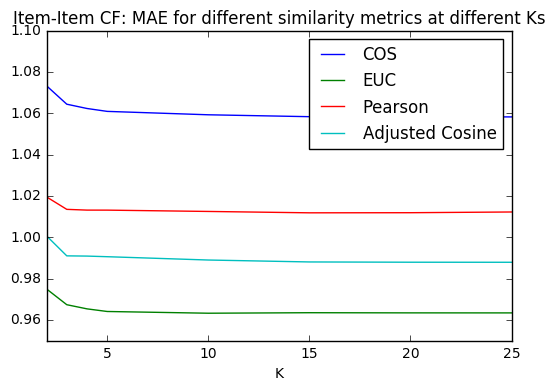

In [25]:
results_df1 = pd.DataFrame({'K': k, 'COS': cos_res, 'EUC': euc_res, 'Pearson': pr_res, 'Adjusted Cosine': adjcos_res})
plot1 = results_df1.plot(x='K', y=['COS', 'EUC', 'Pearson', 'Adjusted Cosine'], ylim=(0.95, 1.1), title = 'Item-Item CF: MAE for different similarity metrics at different Ks')
fig = plot1.get_figure()
fig.savefig('../figures/Kmae_item.png')

### Plot of RMSE

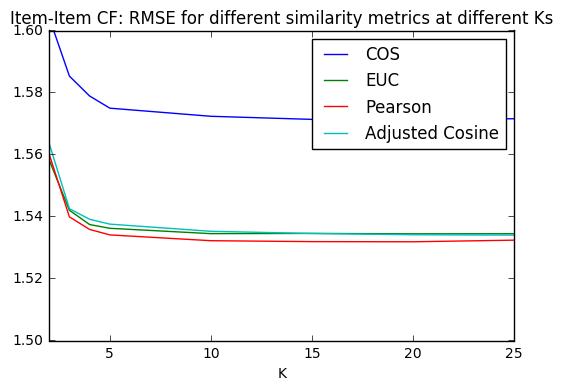

In [26]:
cos_res = sims_rmse[1]
euc_res = sims_rmse[0]
pr_res = sims_rmse[3]
adjcos_res = sims_rmse[4]
k = [2, 3, 4, 5, 10, 15, 20, 25]
results_df1 = pd.DataFrame({'K': k, 'COS': cos_res, 'EUC': euc_res, 'Pearson': pr_res, 'Adjusted Cosine': adjcos_res})
plot1 = results_df1.plot(x='K', y=['COS', 'EUC', 'Pearson', 'Adjusted Cosine'], ylim=(1.5, 1.6), title = 'Item-Item CF: RMSE for different similarity metrics at different Ks')
fig = plot1.get_figure()
fig.savefig('../figures/Krmse_item.png')

We observe that there is no significant change in rmse and mae values beyond k =5, simple explaination of these can be that average books rated per user is around 3.3

In [53]:
import time
trtimer = []
tetimer = []
for data1 in datasets:
    rows1 = data1.user_id.unique()
    cols1 = data1['Book-Title'].unique()
    print(data1.user_id.nunique(), data1.isbn.nunique())
    data1 = data1[['user_id', 'Book-Title', 'book_rating']]
    
    idict  = dict(zip(cols1, range(len(cols1))))
    udict = dict(zip(rows1, range(len(rows1))))
    
    data1.user_id = [
    udict[i] for i in data1.user_id
    ]
    data1['Book-Title'] = [
    idict[i] for i in data1['Book-Title']
    ]
    
    nmat1 = data1.as_matrix()
    trt, tet = get_results(nmat1, 'euc', len(rows1), len(cols1), 5, 5, True)
    
    trtimer.append(trt)
    tetimer.append(tet)

    print()

2517 100
----------   Fold  1 ---------------


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training Time :  1.2959749698638916
Train Errors
RMSE : 0.3009
MAE : 0.1471
Prediction Time :  0.03315901756286621
Test Errors
RMSE : 1.5606
MAE : 0.9771

3086 150
----------   Fold  1 ---------------
Training Time :  3.4505748748779297
Train Errors
RMSE : 0.2923
MAE : 0.1374
Prediction Time :  0.06331110000610352
Test Errors
RMSE : 1.5621
MAE : 0.9972

3543 200
----------   Fold  1 ---------------
Training Time :  6.2445690631866455
Train Errors
RMSE : 0.2718
MAE : 0.1257
Prediction Time :  0.05825400352478027
Test Errors
RMSE : 1.5301
MAE : 0.9583

4280 300
----------   Fold  1 ---------------
Training Time :  19.66141104698181
Train Errors
RMSE : 0.2572
MAE : 0.1115
Prediction Time :  0.07999801635742188
Test Errors
RMSE : 1.5282
MAE : 0.9387

5282 500
----------   Fold  1 ---------------
Training Time :  76.0420880317688
Train Errors
RMSE : 0.2256
MAE : 0.0944
Prediction Time :  0.11560916900634766
Test Errors
RMSE : 1.4864
MAE : 0.9209



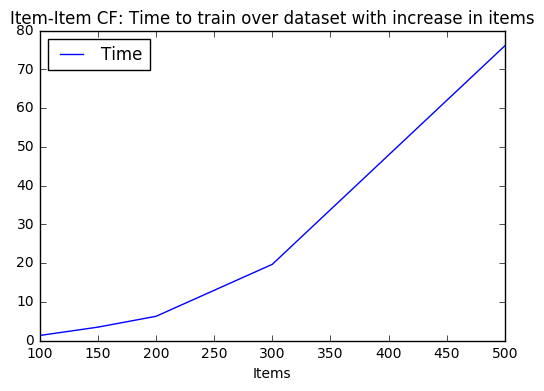

In [55]:
results_df1 = pd.DataFrame({'Items': [100, 150, 200, 300, 500], 'Time': trtimer})
plot1 = results_df1.plot(x='Items', y='Time', ylim=(0, 80), title = 'Item-Item CF: Time to train over dataset with increase in items')
fig = plot1.get_figure()
fig.savefig('../figures/traintime.png')

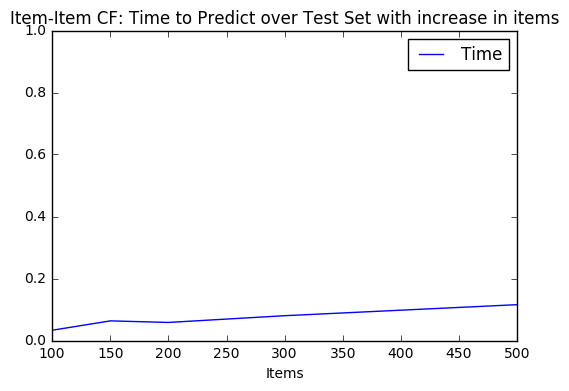

In [59]:
results_df1 = pd.DataFrame({'Items': [100, 150, 200, 300, 500], 'Time': tetimer})
plot1 = results_df1.plot(x='Items', y='Time', ylim=(0, 1), title = 'Item-Item CF: Time to Predict over Test Set with increase in items')
fig = plot1.get_figure()
fig.savefig('../figures/testtime.png')

getmrec function is used to get top m recommendation for a user_id based on the similarity matrix (option), k neighbours.

In [30]:
full_mat = np.zeros((len(rows),len(cols)))
for row in nmat:
    full_mat[row[0], row[1]] = row[2]
item_similarity, amean, umean, imean = itemsimilar(full_mat, 'euc')

In [31]:
def getmrec(full_mat, user_id, item_similarity, k, m, idict,  cov = False):
    
    n = item_similarity.shape[0]
    nzero = full_mat[user_id].nonzero()[0]
    
    preds = {}
    for row in range(n):
        preds[row] = predict(user_id, row, full_mat, item_similarity, amean, umean, imean, k)
    
    flipped_dict = dict(zip(idict.values(), idict.keys()))
    
    if not cov:
        print("Books Read -----")
        for i in nzero:
            print(flipped_dict[i])
            del preds[i]
    
    
    res = sorted(preds.items(), key=lambda x: x[1], reverse = True)
    
    ans = [flipped_dict[i[0]] for i in res[:m]]
    return ans

In [32]:
for m in [5, 8, 10, 15]:   
    cov = []
    for i in range(len(rows)):
        cov.extend(getmrec(full_mat, i, item_similarity, 5, m, idict, True))
    print("Coverage with", m, "recs:", len(set(cov)), "%")

Coverage with 5 recs: 92 %
Coverage with 8 recs: 95 %
Coverage with 10 recs: 99 %
Coverage with 15 recs: 100 %


In [33]:
getmrec(full_mat, 313, item_similarity, 5, 10, idict)

Books Read -----
Purity in Death
Divine Secrets of the Ya-Ya Sisterhood : A Novel
Ender's Game (Ender Wiggins Saga (Paperback))
Middlesex: A Novel
Invisible Man


['Pigs in Heaven',
 "A Thousand Acres (Ballantine Reader's Circle)",
 'Chicken Soup for the Soul (Chicken Soup for the Soul)',
 "Pretend You Don't See Her",
 'Seabiscuit',
 'Wild Animus',
 "Left Behind: A Novel of the Earth's Last Days (Left Behind #1)",
 "A Second Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series)",
 'About a Boy (Movie Tie-In)',
 "The Princess Bride: S Morgenstern's Classic Tale of True Love and High Adventure"]

# Algo 2:  Model Based Algorithm : NMF

We used scikit-surprise to implement NMF and tune its hyperparameter and regularisation. We made an attempt at manually implement NMF but the evaluation metrics were not as comparable to regularised NMF using surprise-scikit. The code for manual NMF can be found in `analyze/NMF.ipynb`

In [34]:
from surprise import evaluate, Reader, Dataset, SVD, NMF, GridSearch, KNNWithMeans

In [35]:
reader = Reader(rating_scale=(1, 10))
data2 = Dataset.load_from_df(data[['user_id', 'Book-Title', 'book_rating']], reader)
data2.split(5)


In [36]:
param_grid = {'n_factors': [30, 40, 50, 60, 70], 'n_epochs': [40, 50, 60], 'reg_pu': [0.001, 0.1, 1],
              'reg_qi': [ 0.1, 1, 3, 5]}
grid_search = GridSearch(NMF, param_grid, measures=['RMSE', 'MAE'])
grid_search.evaluate(data2)
results_df = pd.DataFrame.from_dict(grid_search.cv_results)
print(results_df)

[{'n_epochs': 40, 'reg_pu': 0.001, 'n_factors': 30, 'reg_qi': 0.1}, {'n_epochs': 40, 'reg_pu': 0.1, 'n_factors': 30, 'reg_qi': 0.1}, {'n_epochs': 40, 'reg_pu': 1, 'n_factors': 30, 'reg_qi': 0.1}, {'n_epochs': 40, 'reg_pu': 0.001, 'n_factors': 40, 'reg_qi': 0.1}, {'n_epochs': 40, 'reg_pu': 0.1, 'n_factors': 40, 'reg_qi': 0.1}, {'n_epochs': 40, 'reg_pu': 1, 'n_factors': 40, 'reg_qi': 0.1}, {'n_epochs': 40, 'reg_pu': 0.001, 'n_factors': 50, 'reg_qi': 0.1}, {'n_epochs': 40, 'reg_pu': 0.1, 'n_factors': 50, 'reg_qi': 0.1}, {'n_epochs': 40, 'reg_pu': 1, 'n_factors': 50, 'reg_qi': 0.1}, {'n_epochs': 40, 'reg_pu': 0.001, 'n_factors': 60, 'reg_qi': 0.1}, {'n_epochs': 40, 'reg_pu': 0.1, 'n_factors': 60, 'reg_qi': 0.1}, {'n_epochs': 40, 'reg_pu': 1, 'n_factors': 60, 'reg_qi': 0.1}, {'n_epochs': 40, 'reg_pu': 0.001, 'n_factors': 70, 'reg_qi': 0.1}, {'n_epochs': 40, 'reg_pu': 0.1, 'n_factors': 70, 'reg_qi': 0.1}, {'n_epochs': 40, 'reg_pu': 1, 'n_factors': 70, 'reg_qi': 0.1}, {'n_epochs': 40, 'reg_pu

In [37]:
print(grid_search.best_score['RMSE'])
print(grid_search.best_params['RMSE'])
print(grid_search.best_score['MAE'])
print(grid_search.best_params['MAE'])


1.53559006122
{'n_epochs': 50, 'reg_pu': 0.001, 'n_factors': 60, 'reg_qi': 5}
0.978589949289
{'n_epochs': 60, 'reg_pu': 0.001, 'n_factors': 50, 'reg_qi': 3}


60 latent factor seem to be optimal, 

In [67]:
maelist = []
rmselist = []
factors = [20, 30, 40 ,50 ,60, 70, 80]
for i in factors:
    algo = NMF(n_factors = i, reg_pu = 0.001, reg_qi = 3)
    perf = evaluate(algo, data2)
    maelist.append(np.mean(perf['mae']))
    rmselist.append(np.mean(perf['rmse']))
    

Evaluating RMSE, MAE of algorithm NMF.

------------
Fold 1
RMSE: 1.5361
MAE:  1.0125
------------
Fold 2
RMSE: 1.6069
MAE:  1.0474
------------
Fold 3
RMSE: 1.5928
MAE:  1.0471
------------
Fold 4
RMSE: 1.5861
MAE:  1.0453
------------
Fold 5
RMSE: 1.5574
MAE:  1.0176
------------
------------
Mean RMSE: 1.5759
Mean MAE : 1.0340
------------
------------
Evaluating RMSE, MAE of algorithm NMF.

------------
Fold 1
RMSE: 1.5333
MAE:  0.9861
------------
Fold 2
RMSE: 1.5837
MAE:  0.9955
------------
Fold 3
RMSE: 1.5855
MAE:  1.0074
------------
Fold 4
RMSE: 1.5966
MAE:  1.0258
------------
Fold 5
RMSE: 1.5514
MAE:  0.9984
------------
------------
Mean RMSE: 1.5701
Mean MAE : 1.0026
------------
------------
Evaluating RMSE, MAE of algorithm NMF.

------------
Fold 1
RMSE: 1.5015
MAE:  0.9667
------------
Fold 2
RMSE: 1.5848
MAE:  0.9986
------------
Fold 3
RMSE: 1.5501
MAE:  0.9791
------------
Fold 4
RMSE: 1.5714
MAE:  1.0055
------------
Fold 5
RMSE: 1.5558
MAE:  0.9890
------------
-

### Plot of varying evaluation metrics vs number of latent factors for NMF

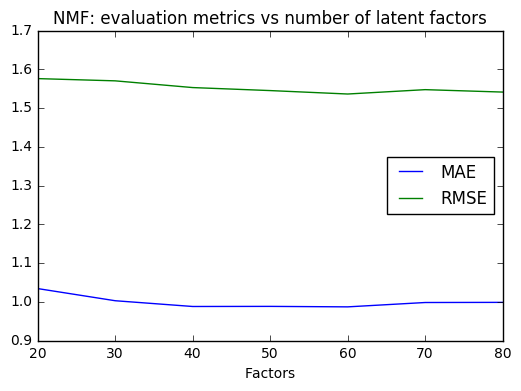

In [68]:
results_df = pd.DataFrame({'Factors': factors, 'MAE': maelist, 'RMSE': rmselist})
plot1 = results_df.plot(x='Factors', y=['MAE', 'RMSE'], ylim=(0.9, 1.7), title = 'NMF: evaluation metrics vs number of latent factors')
fig = plot1.get_figure()
fig.savefig('../figures/NMFfactor.png')

In [46]:
from collections import defaultdict
def get_top_n(predictions, n=10):

    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


trainset = data2.build_full_trainset()
algo = NMF(n_epochs = 60, n_factors = 50, reg_pu = 0.001, reg_qi = 3)
algo.train(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user


RecBooks is used to recommend books to a user.

In [77]:
def recbooks(mat, user_id, idict, cov = False):
    full_mat = np.zeros((len(rows),len(cols)))
    for row in mat:
        full_mat[row[0], row[1]] = row[2]
    
    nzero = full_mat[user_id].nonzero()[0]
    
    flipped_dict = dict(zip(idict.values(), idict.keys()))
    ans = [flipped_dict[i[0]] for i in top_n[user_id]]
    if not cov:
        print("Books Read -----")
        for i in nzero:
            print(flipped_dict[i])
        print()
        print("Recs -----")
        for i in ans:
            print(i)
    return ans

recbooks(nmat, 1,idict)

Books Read -----
A Second Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series)
Seabiscuit
The God of Small Things
Plainsong (Vintage Contemporaries)
Manhattan Hunt Club
Divine Secrets of the Ya-Ya Sisterhood : A Novel
Fall On Your Knees (Oprah #45)

Recs -----
Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series (Paper))
Invisible Man
Vittorio the Vampire: New Tales of the Vampires
Bridget Jones : The Edge of Reason
Table For Two
The Four Agreements: A Practical Guide to Personal Freedom
Purity in Death
On the Road (Penguin 20th Century Classics)
Black and Blue
Roses Are Red (Alex Cross Novels)
Pretend You Don't See Her
Someone to Watch Over Me : A Novel
All That Remains (Kay Scarpetta Mysteries (Paperback))
Guilty as Sin
The Color of Water: A Black Man's Tribute to His White Mother


["Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series (Paper))",
 'Invisible Man',
 'Vittorio the Vampire: New Tales of the Vampires',
 'Bridget Jones : The Edge of Reason',
 'Table For Two',
 'The Four Agreements: A Practical Guide to Personal Freedom',
 'Purity in Death',
 'On the Road (Penguin 20th Century Classics)',
 'Black and Blue',
 'Roses Are Red (Alex Cross Novels)',
 "Pretend You Don't See Her",
 'Someone to Watch Over Me : A Novel',
 'All That Remains (Kay Scarpetta Mysteries (Paperback))',
 'Guilty as Sin',
 "The Color of Water: A Black Man's Tribute to His White Mother"]

#### Coverage : Percentage of books coverage from all the books when recommending top-m books 

In [48]:
for m in [5, 8, 10, 15]:   
    cov = []
    top_n = get_top_n(predictions, m)
    for i in range(len(rows)):
        cov.extend(recbooks(nmat, i,idict, True))
    print("Coverage with", m, "recs:", len(set(cov)), "%")

Coverage with 5 recs: 81 %
Coverage with 8 recs: 87 %
Coverage with 10 recs: 92 %
Coverage with 15 recs: 95 %


### NMF Scaling with items

In [49]:
trtimer = []
tetimer = []
for data4 in datasets:
    rows4 = data4.user_id.unique()
    cols4 = data4['Book-Title'].unique()
    print(data4.user_id.nunique(), data4.isbn.nunique())
    data4 = data4[['user_id', 'Book-Title', 'book_rating']]
    
    idict  = dict(zip(cols4, range(len(cols4))))
    udict = dict(zip(rows4, range(len(rows4))))
    
    data4.user_id = [
    udict[i] for i in data4.user_id
    ]
    data4['Book-Title'] = [
    idict[i] for i in data4['Book-Title']
    ]
    
    start = time.time()
    
    reader = Reader(rating_scale=(1, 10))
    data4 = Dataset.load_from_df(data4[['user_id', 'Book-Title', 'book_rating']], reader)
    data4.split(5)
    
    trainset = data4.build_full_trainset()
    algo = NMF(n_epochs = 60, n_factors = 70, reg_pu = 0.001, reg_qi = 5)
    
    
    algo.train(trainset)
    end = time.time()
    
    trt = end - start
    print(trt)
    
    testset = trainset.build_testset()
    
    start = time.time()
    predictions = algo.test(testset)
    end = time.time()
    
    tet = end - start
    print(tet)
    
    trtimer.append(trt)
    tetimer.append(tet)

    print()


2517 100


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2.0220389366149902
0.12902402877807617

3086 150
2.6030781269073486
0.08180785179138184

3543 200
3.2038509845733643
0.10391497611999512

4280 300
4.060749053955078
0.12465620040893555

5282 500
5.435039043426514
0.16994094848632812



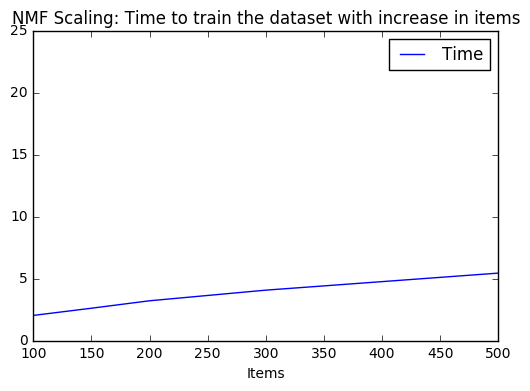

In [50]:
results_df1 = pd.DataFrame({'Items': [100, 150, 200, 300, 500], 'Time': trtimer})
plot1 = results_df1.plot(x='Items', y='Time', ylim=(0, 25), title = 'NMF Scaling: Time to train the dataset with increase in items')
fig = plot1.get_figure()
fig.savefig('../figures/traintimeNMF.png')

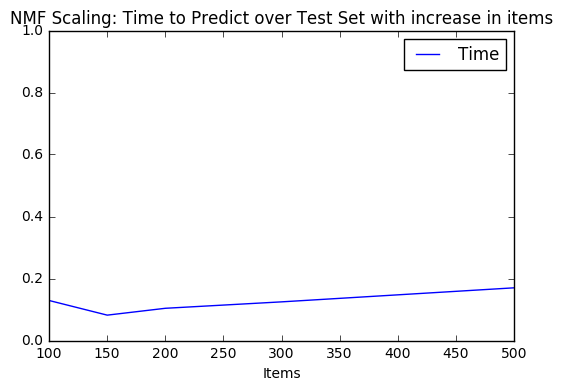

In [52]:
results_df1 = pd.DataFrame({'Items': [100, 150, 200, 300, 500], 'Time': tetimer})
plot1 = results_df1.plot(x='Items', y='Time', ylim=(0, 1), title = 'NMF Scaling: Time to Predict over Test Set with increase in items')
fig = plot1.get_figure()
fig.savefig('../figures/testtimeNMF.png')

### Comparing our implementation with Surprise

In [71]:
sim_options = {
    'name': 'MSD',
    'user_based' : False
}
algo = KNNWithMeans(sim_options = sim_options, k = 5, min_k =2)

In [72]:
perf = evaluate(algo, data2)

Evaluating RMSE, MAE of algorithm KNNWithMeans.

------------
Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.5986
MAE:  1.1492
------------
Fold 2
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.5865
MAE:  1.1323
------------
Fold 3
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.6025
MAE:  1.1575
------------
Fold 4
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.5493
MAE:  1.1212
------------
Fold 5
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.5827
MAE:  1.1369
------------
------------
Mean RMSE: 1.5839
Mean MAE : 1.1394
------------
------------
